# Evaluationf or User x User Feedback

Using the IMDB and MovieLens data, we build a feature matrix that we can use for user-user and item-item recommendation.

Here, we construct an User-User based recsys and evaluate it against our baseline.

In [1]:
%matplotlib inline

In [2]:
import json
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from collections import Counter

from scipy.sparse import lil_matrix
from scipy.stats import pearsonr
from scipy.stats import spearmanr

from sklearn.neighbors import DistanceMetric
from sklearn.metrics import mean_squared_error
from sklearn.metrics import jaccard_score
from sklearn.metrics import pairwise_distances

In [3]:
known_movies = set()

user_ratings = {} # List of all our movie ratings for specific users
movie_ids = []

with open("../data/user_ratings.json", "r") as in_file:
    for line in in_file:
        
        this_rating = json.loads(line)
        
        known_movies.add(this_rating["title_id"])
        
        if this_rating["title_id"] not in movie_ids:
            movie_ids.append(this_rating["title_id"])
        
        this_users_ratings = user_ratings.get(this_rating["userId"], [])
        this_users_ratings.append((this_rating["title_id"], this_rating["rating"]))
        
        user_ratings[this_rating["userId"]] = this_users_ratings
        
        

In [4]:
movie_id_to_index = {m:i for i,m in enumerate(movie_ids)}

In [5]:
print("Known Users:", len(user_ratings))
print("Known Movies:", len(known_movies))


Known Users: 2244
Known Movies: 4465


In [6]:
actor_id_to_name_map = {}     # Map Actor IDs to actor names
actor_id_to_index_map = {}    # Map actor IDs to a unique index of known actors
index_to_actor_ids = []       # Array mapping unique index back to actor ID (invert of actor_id_to_index_map)

index_counter = 0    # Unique actor index; increment for each new actor
known_actors = set()

movie_actor_map = {} # List of all our movies and their actors

test_count = 0
with open("../data/imdb_recent_movies.json", "r") as in_file:
    for line in in_file:
        
        this_movie = json.loads(line)
        
        # Restrict to known movies
        if this_movie["title_id"] not in known_movies:
            continue
            
        # Keep track of all the actors in this movie
        for actor_id,actor_name in zip(this_movie['actor_ids'],this_movie['actor_names']):
            
            # Keep names and IDs
            actor_id_to_name_map[actor_id] = actor_name
            
            # If we've seen this actor before, skip...
            if actor_id in known_actors:
                continue
                
            # ... Otherwise, add to known actor set and create new index for them
            known_actors.add(actor_id)
            actor_id_to_index_map[actor_id] = index_counter
            index_to_actor_ids.append(actor_id)
            index_counter += 1
            
        # Finished with this film
        movie_actor_map[this_movie["title_id"]] = ({
            "movie": this_movie["title_name"],
            "actors": set(this_movie['actor_ids']),
            "genres": this_movie["title_genre"]
        })

In [7]:
print("Known Actors:", len(known_actors))
print("Known Movies:", len(movie_actor_map))

Known Actors: 5224
Known Movies: 4465


## Generate DataFrame using Sparse Matrics

Convert our Movie Ratings data into a DataFrame that we can use for analysis.

In [8]:
# With sparse matrix, initialize to size of Users x Movies of 0s
matrix_sparse = lil_matrix((len(user_ratings), len(known_movies)), dtype=float)

# Update the matrix, user by user, setting non-zero values for the appropriate actors
for row,this_user in enumerate(user_ratings): 
    this_user_ratings = user_ratings[this_user]
    
    for movie_id,rating in this_user_ratings:
        this_movie_index = movie_id_to_index[movie_id]
        matrix_sparse[row,this_movie_index] = rating

In [9]:
df = pd.DataFrame.sparse.from_spmatrix(
    matrix_sparse, 
    index=[u for u in user_ratings],
    columns=movie_ids
).T
df

,10,37,51,126,152,263,284,448,626,706,...,162002,162073,162207,162257,162363,162420,162434,162464,162499,162537
tt0274309,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0298203,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0315733,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0337563,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0463854,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt4241904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
tt1666800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
tt6806448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0844671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [10]:
print("Movies x Users dimensionality:", df.shape)

Movies x Users dimensionality: (4465, 2244)


## Hold Out Data for Evaluation

We want to extract a set of test users on which we can evaluate our recsys. For each test user, we need to split their behavior into a seen set that we can use for recommendation and an unseen set we can use for evaluation.

In [11]:
user_by_movie_df = df.T

In [12]:
held_out_users = np.random.choice(user_by_movie_df.index, size=100)
held_out_users

array(['90141', '45450', '82463', '109791', '36559', '6877', '130526',
       '35082', '78135', '65628', '98222', '49531', '42369', '33565',
       '107331', '83897', '4378', '12198', '119561', '121928', '17667',
       '154738', '26309', '36959', '48019', '66431', '97011', '138778',
       '19023', '143461', '87529', '119146', '101503', '1884', '110327',
       '73417', '20692', '61616', '43842', '4848', '22754', '72909',
       '37766', '13804', '112088', '142616', '50171', '88630', '107026',
       '162464', '148122', '42369', '73463', '3085', '61557', '144562',
       '84580', '83618', '149319', '67032', '30384', '34103', '108295',
       '82824', '27916', '122209', '150681', '83897', '40408', '37746',
       '135316', '115974', '43239', '42433', '23802', '46207', '49710',
       '2773', '108340', '77694', '123840', '157211', '123462', '148858',
       '140675', '100176', '57878', '41243', '31709', '42145', '17632',
       '161805', '10022', '97923', '33969', '67999', '77841', '330

In [13]:
held_out_movies = np.random.choice(user_by_movie_df.columns, size=100)

In [14]:
# This new DataFrame has zeros where ratings used to be
training_df = user_by_movie_df.sparse.to_dense()
for test_user in held_out_users:
    for test_movie in held_out_movies:
        training_df.loc[test_user][test_movie] = 0.0

### Baseline Recs using Most Popular Movies

As a baseline, let's rank movies by their global popularity

In [15]:
# Let's make a dataframe of just the training users, so we can evaluate
held_in_users_df = training_df.loc[[u for u in training_df.index if u not in held_out_users]]

In [16]:
agg_movie_ratings_ = held_in_users_df.sum(axis=0)
agg_movie_ratings = 5 * (agg_movie_ratings_ / agg_movie_ratings_.max())

for movie_id,sum_rating in agg_movie_ratings.sort_values(ascending=False).head(20).items():
    print(movie_id, movie_actor_map[movie_id]["movie"], sum_rating)

tt0209144 Memento 5.0
tt0172495 Gladiator 4.895211994196357
tt1375666 Inception 4.769466387231985
tt0126029 Shrek 4.492181202643882
tt0338013 Eternal Sunshine of the Spotless Mind 4.130259551829759
tt0266543 Finding Nemo 3.950507818797356
tt0198781 Monsters, Inc. 3.825568273416089
tt0266697 Kill Bill: Vol. 1 3.761889408350798
tt0910970 WALL·E 3.3596646783814283
tt0372784 Batman Begins 3.3419313235531196
tt0240772 Ocean's Eleven 3.2919555054006127
tt0378194 Kill Bill: Vol. 2 3.2476221183298404
tt0120903 X-Men 3.1275189424472027
tt0246578 Donnie Darko 3.1242946961147835
tt0181689 Minority Report 3.0920522327905853
tt0264464 Catch Me If You Can 3.023536998226665
tt1049413 Up 3.0049975818152506
tt0145487 Spider-Man 2.8800580364339834
tt0162222 Cast Away 2.847009511526681
tt0361748 Inglourious Basterds 2.763985168466871


## Function for Generating Recommendations based on User Similarity

In [57]:
def recs_for_user(query_user, local_df, top_k=5, threshold=0.33, centering=False):

    # use centered matrix if needed
    user_rating_centered_df = local_df
    
    if centering:
        # center user ratings
        centers = local_df.apply(lambda row: np.mean([x for x in row if x > 0]), axis=1)
        centers_map = {uid:c for uid,c in centers.items()}
        user_rating_centered_df = pd.DataFrame([[v-centers_map[uid] if v > 0 else 0 for v in row] for uid,row in local_df.iterrows()])
        user_rating_centered_df.index = local_df.index
        user_rating_centered_df.columns = local_df.columns    
    
    # Find movies this query user has ranked
    query_ranked_movies = local_df.columns[local_df.loc[query_user] > 0]

    # Find just the user's ratings and calc pairwise distances between that rating and all others
    user_distances = pairwise_distances([user_rating_centered_df.loc[query_user]], user_rating_centered_df, metric="cosine")

    # Convert to similarity rather than distance and apply threshold
    user_sims = 1-user_distances
    user_sims = [s if s > threshold else 0.0 for s in user_sims[0,:]]

    # Create a new DF of users based on similarity to the query user
    user_user_sim_df = pd.DataFrame(user_sims, index=user_rating_centered_df.index, columns=["similarity"])

    # Find the top-k most similar users 
    relevant_users_df = user_user_sim_df.sort_values(by="similarity").tail(top_k + 1)

    # Create a map of user IDs to similarity, since we use that later for re-weighting ratings
    relevant_users_sims = {uid:row["similarity"] for uid,row in relevant_users_df.iterrows()}

    # We only care about rating movies that the user has NOT seen
    query_unranked_movies = user_rating_centered_df.columns[user_rating_centered_df.loc[query_user] == 0]

    # Get the IDs for the top-k similar users, excluding the query user, who will always have a high sim score
    sim_user_index = [u for u in relevant_users_df.index if u != query_user]
    unseen_sim_user_rankings_df = local_df[query_unranked_movies].loc[sim_user_index]

    # List for storing our predicted ratings
    inferred_movie_ratings = []

    # Transpose the similar-user X movies DF, and iterate through each movie...
    for movie_id,ratings in unseen_sim_user_rankings_df.T.iterrows():

        # If no similar user has rated any movie here, skip this movie
        non_zero_ratings = ratings[ratings > 0]
        if non_zero_ratings.shape[0] < 1:
            inferred_movie_ratings.append((movie_id, 0.0))
            continue
        
        # If all users have zero similarity, skip
        if sum([relevant_users_sims[this_user_id] for this_user_id,_ in non_zero_ratings.items()]) == 0:
            inferred_movie_ratings.append((movie_id, 0.0))
            continue

        # Weight the ratings for this movie based on the relevant users and their similarities
        this_summed_score = sum([
            relevant_users_sims[this_user_id] * this_rating  for this_user_id,this_rating in non_zero_ratings.items()
        ])    

        # Normalize based on user similarity
        this_summed_sim = sum([relevant_users_sims[this_user_id] for this_user_id,this_rating in non_zero_ratings.items()])
        
        # Calculate inferred score
        inferred_rating = this_summed_score / this_summed_sim    
        inferred_movie_ratings.append((movie_id, inferred_rating))

    inferred_ratings = pd.Series([r for m,r in inferred_movie_ratings])
    inferred_ratings.index = [m for m,r in inferred_movie_ratings]
    
    return inferred_ratings


In [58]:
recs_for_user("90141", training_df, top_k=5, threshold=0.5, centering=False).sort_values(ascending=False).mean()

0.035326086956521736

### Evaluate This Baseline on the Held-Out Users

In [59]:
# For Precision@k, set k to a reasonably low value
#. It's low because we don't want to provide many recommendations
top_k = 3

In [60]:
base_metrics = []

for u in held_out_users:

    this_held_out_movies = user_by_movie_df.loc[u][held_out_movies]
    if sum(this_held_out_movies) == 0:
        print("Skipping user with no ratings in held-out set:", u)
        continue

    # Calculate mean squared error
    mse = mean_squared_error(this_held_out_movies, agg_movie_ratings[held_out_movies])
    
    # Pearson correlation for rankings
    corr_p = pearsonr(this_held_out_movies, agg_movie_ratings[held_out_movies])[0]
    
    # Spearman correlation for *rankings* rather than overall ratings
    corr_s = spearmanr(this_held_out_movies, agg_movie_ratings[held_out_movies]).correlation
    
    # Top k rankings, i.e., what's the similarity between the top-k for this user and all the dataset?
    this_top_k = set(this_held_out_movies.sort_values(ascending=False).head(top_k).keys())
    global_top_k = set(agg_movie_ratings[held_out_movies].sort_values(ascending=False).head(top_k).keys())

    # What's the Precision between this user's top-k and global top-k?
    precision_at_k = len(this_top_k.intersection(global_top_k)) / len(this_top_k)
    
    base_metrics.append({
        "mse": mse,
        "pearson": corr_p,
        "spearman": corr_s,
        "pr@k": precision_at_k,
    })
    

Skipping user with no ratings in held-out set: 45450
Skipping user with no ratings in held-out set: 36559
Skipping user with no ratings in held-out set: 6877
Skipping user with no ratings in held-out set: 130526
Skipping user with no ratings in held-out set: 35082
Skipping user with no ratings in held-out set: 78135
Skipping user with no ratings in held-out set: 98222
Skipping user with no ratings in held-out set: 107331
Skipping user with no ratings in held-out set: 83897
Skipping user with no ratings in held-out set: 4378
Skipping user with no ratings in held-out set: 12198
Skipping user with no ratings in held-out set: 17667
Skipping user with no ratings in held-out set: 66431
Skipping user with no ratings in held-out set: 97011
Skipping user with no ratings in held-out set: 19023
Skipping user with no ratings in held-out set: 1884
Skipping user with no ratings in held-out set: 61616
Skipping user with no ratings in held-out set: 142616
Skipping user with no ratings in held-out set:

In [61]:
base_metrics_df = pd.DataFrame(base_metrics)
base_metrics_df.mean()

mse         0.334034
pearson     0.595532
spearman    0.222032
pr@k        0.374269
dtype: float64

In [71]:
new_metrics = []

for u in held_out_users:

    this_held_out_movies = user_by_movie_df.loc[u][held_out_movies]
    if sum(this_held_out_movies) == 0:
        print("Skipping user with no ratings in held-out set:", u)
        continue
        
    u2u_movie_ratings = recs_for_user(u, training_df, 20, threshold=0.5, centering=False)

    # Calculate mean squared error
    mse = mean_squared_error(this_held_out_movies, u2u_movie_ratings[held_out_movies])
    
    # Pearson correlation for rankings
    corr_p = pearsonr(this_held_out_movies, u2u_movie_ratings[held_out_movies])[0]
    
    # Spearman correlation for *rankings* rather than overall ratings
    corr_s = spearmanr(this_held_out_movies, u2u_movie_ratings[held_out_movies]).correlation
    
    # Top k rankings, i.e., what's the similarity between the top-k for this user and all the dataset?
    this_top_k = set(this_held_out_movies.sort_values(ascending=False).head(top_k).keys())
    global_top_k = set(u2u_movie_ratings[held_out_movies].sort_values(ascending=False).head(top_k).keys())

    # What's the Precision between this user's top-k and global top-k?
    precision_at_k = len(this_top_k.intersection(global_top_k)) / len(this_top_k)
    
    new_metrics.append({
        "mse": mse,
        "pearson": corr_p,
        "spearman": corr_s,
        "pr@k": precision_at_k,
    })
    


Skipping user with no ratings in held-out set: 45450


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 36559
Skipping user with no ratings in held-out set: 6877
Skipping user with no ratings in held-out set: 130526
Skipping user with no ratings in held-out set: 35082
Skipping user with no ratings in held-out set: 78135


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 98222


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/

Skipping user with no ratings in held-out set: 107331
Skipping user with no ratings in held-out set: 83897
Skipping user with no ratings in held-out set: 4378
Skipping user with no ratings in held-out set: 12198


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 17667


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 66431
Skipping user with no ratings in held-out set: 97011


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 19023


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/

Skipping user with no ratings in held-out set: 1884


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 61616


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/

Skipping user with no ratings in held-out set: 142616


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 88630


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/

Skipping user with no ratings in held-out set: 3085


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 84580


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 67032


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/

Skipping user with no ratings in held-out set: 83897
Skipping user with no ratings in held-out set: 40408
Skipping user with no ratings in held-out set: 37746
Skipping user with no ratings in held-out set: 135316


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/

Skipping user with no ratings in held-out set: 23802


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 49710
Skipping user with no ratings in held-out set: 2773


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 77694
Skipping user with no ratings in held-out set: 123840
Skipping user with no ratings in held-out set: 157211


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 140675
Skipping user with no ratings in held-out set: 100176
Skipping user with no ratings in held-out set: 57878


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 31709
Skipping user with no ratings in held-out set: 42145
Skipping user with no ratings in held-out set: 17632
Skipping user with no ratings in held-out set: 161805


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 67999
Skipping user with no ratings in held-out set: 77841
Skipping user with no ratings in held-out set: 33047
Skipping user with no ratings in held-out set: 130857


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [72]:
new_metrics_df = pd.DataFrame(new_metrics)
new_metrics_df.mean()

mse         0.426602
pearson     0.586040
spearman    0.577216
pr@k        0.350877
dtype: float64

## Visually Compare Metrics

Plot the performance metrics between the baseline and provided recommendations, with ~95% confidence interval error bars, so we can see whether we get significant increases.

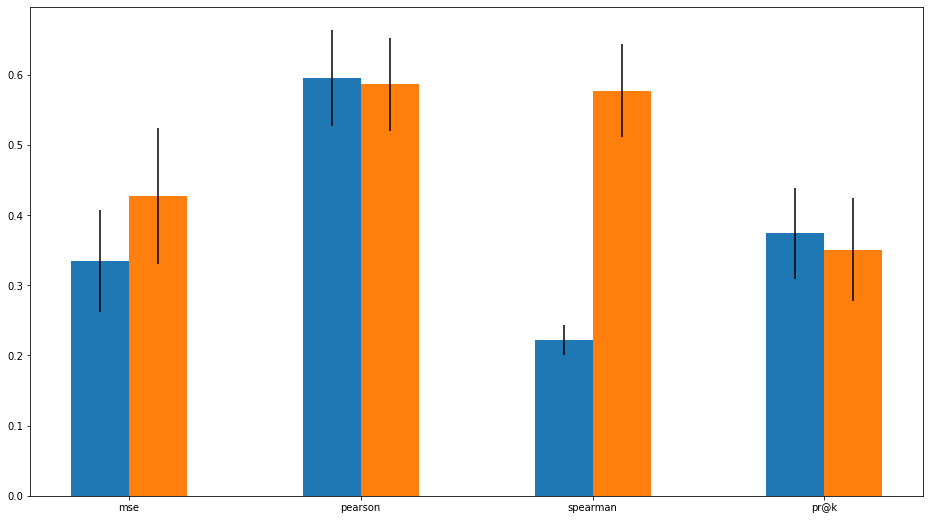

In [73]:
figure = plt.figure(figsize=(16,9))
ax = figure.add_subplot(1,1,1)

base_metric_err = 2*base_metrics_df.std() / np.sqrt(base_metrics_df.shape[0])
new_metric_err = 2 * new_metrics_df.std() / np.sqrt(new_metrics_df.shape[0])

width = 0.25
ax.bar(x=[x-width/2 for x in range(4)], height=base_metrics_df.mean(), yerr=base_metric_err, width=width)
ax.bar(x=[x+width/2 for x in range(4)], height=new_metrics_df.mean(), yerr=new_metric_err,  width=width)

ax.set_xticks(range(4))
ax.set_xticklabels(base_metrics_df.columns)

plt.show()